In [1]:
from pandas import read_csv
from pandas import concat
from pandas import Series
import numpy as np
from keras import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from IPython.display import display
from math import ceil

%matplotlib inline

Using TensorFlow backend.


In [2]:
series = read_csv("Microsoft Share Volume.csv")

(2518, 2)
       date       VOL
0  20080102  63083943
1  20080103  49601203
2  20080104  72093831
3  20080107  80226194
4  20080108  79217360


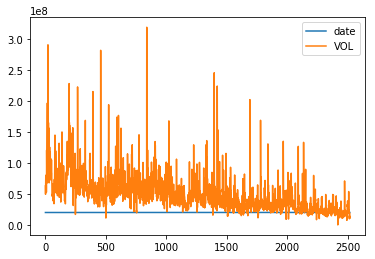

In [3]:
print(series.shape)
print(series.head())
series.plot()

In [4]:
raw_data = series["VOL"]
display(type(raw_data))
display(raw_data.head())

pandas.core.series.Series

0    63083943
1    49601203
2    72093831
3    80226194
4    79217360
Name: VOL, dtype: int64

In [5]:
# Transform Times Series to Stationary

# Function that creates a differenced series
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# Function that calculates the original value based on differenced series
def invert_difference(history, yhat, interval = 1):
    return yhat + history[len(history) - interval]


In [6]:
# Transform Time Series to be stationary

diff_data = difference(raw_data, 1)
display(diff_data.head(), diff_data.shape)

0   -13482740
1    22492628
2     8132363
3    -1008834
4    -4898179
dtype: int64

(2517,)

In [7]:
# Invert Transform

inverted_diff_data = list()
for i in range(len(diff_data)):
    inverted_diff_data.append(invert_difference(raw_data, diff_data[i], len(raw_data) - i))
inverted_diff_data = Series(inverted_diff_data)
display(inverted_diff_data.head())

0    49601203
1    72093831
2    80226194
3    79217360
4    74319181
dtype: int64

In [8]:
# Frame the sequence as a supervised learning problem

diff_data_shifted = [diff_data.shift(1)]
#print(diff_data_shifted)
diff_data_shifted.append(diff_data)
#print(diff_data_shifted)
diff_data_concat = concat(diff_data_shifted, axis=1)
#print(diff_data_concat)
diff_data_concat.fillna(0, inplace=True)   # fill NaN as 0.0
display(diff_data_concat.head())

,0,1
0,0.0,-13482740
1,-13482740.0,22492628
2,22492628.0,8132363
3,8132363.0,-1008834
4,-1008834.0,-4898179


In [9]:
# Divide dataset into training / cross validation / test set
#  with ratio 60% - 20% - 20%

num_train = ceil(len(diff_data_concat) * 0.6)
num_cv = ceil(len(diff_data_concat) * 0.2)
train, cross_val, test = diff_data_concat[:num_train], diff_data_concat[num_train:num_train+num_cv], diff_data_concat[num_train+num_cv:]

train_X, train_y = train[0], train[1]
cross_val_X, cross_val_y = cross_val[0], cross_val[1]
test_X, test_y = test[0], test[1]

display(train_X.shape, cross_val_X.shape, test_X.shape)

(1511,)

(504,)

(502,)

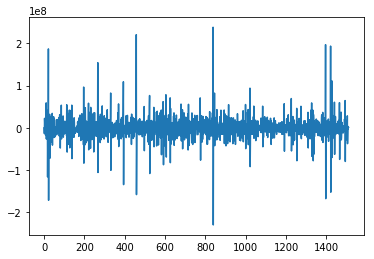

In [10]:
train_X.plot()

In [11]:
# Function that returns a scaler [-1, 1] that fits on the training set
def fit_scaler(train):
    train = train.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    return scaler

# Function that scales a dataset using the given scaler
#  Note: input and return are pandas Series
def scale(dataset, scaler):
    dataset = dataset.values.reshape(-1, 1)
    dataset_scaled = scaler.transform(dataset)
    dataset_scaled = dataset_scaled.squeeze()
    dataset_scaled = Series(dataset_scaled)
    return dataset_scaled

# Function that inverts a dataset using the given scaler
#  Note: input and return are pandas Series
def invert_scale(dataset_scaled, scaler):
    dataset_scaled = dataset_scaled.values.reshape(-1, 1)
    dataset_inverted = scaler.inverse_transform(dataset_scaled)
    dataset_inverted = dataset_inverted.squeeze()
    dataset_inverted = Series(dataset_inverted)
    return dataset_inverted

In [12]:
# Transform Times Series to Scale ([-1, 1])

scaler = fit_scaler(train_X)
train_X_scaled = scale(train_X, scaler)
train_y_scaled = scale(train_y, scaler)
cross_val_X_scaled = scale(cross_val_X, scaler)
cross_val_y_scaled = scale(cross_val_y, scaler)
test_X_scaled = scale(test_X, scaler)
test_y_scaled = scale(test_y, scaler)

In [13]:
# Transform X, y to numpy ndarray and Reshape X to comply with Keras LSTM input dimensions
# (batch_size, timesteps, input_dim)
# Each timestep in the original sequence is one seperate sample in the batch, with one timestep and input dimension of one

X = train_X_scaled.values.reshape(train_X_scaled.shape[0], 1, 1)
y = train_y_scaled.values

display(type(X))
display(X.shape, y.shape)

numpy.ndarray

(1511, 1, 1)

(1511,)

In [24]:
# Build the LSTM Model

def fit_lstm(X, y, batch_size=1, num_epoch=100, neurons=5, show_info=True):
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    history = list()
    for i in range(num_epoch):
        if show_info:
            print("Total Epochs:", i+1, "/", num_epoch)
        history_info = model.fit(X, y, epochs=1, batch_size=batch_size, shuffle=False)
        print("\n")
        model.reset_states()
        history.append(history_info)
    
    return model, history

In [25]:
lstm_model, history = fit_lstm(X, y, num_epoch=100, neurons=100)

Total Epochs: 1 / 100
Epoch 1/1
1511/1511 [==============================] - 4s 3ms/step - loss: 0.0122


Total Epochs: 2 / 100
Epoch 1/1
1511/1511 [==============================] - 3s 2ms/step - loss: 0.0166


Total Epochs: 3 / 100
Epoch 1/1
1511/1511 [==============================] - 3s 2ms/step - loss: 0.0136


Total Epochs: 4 / 100
Epoch 1/1
1511/1511 [==============================] - 3s 2ms/step - loss: 0.0131


Total Epochs: 5 / 100
Epoch 1/1
1511/1511 [==============================] - 3s 2ms/step - loss: 0.0120


Total Epochs: 6 / 100
Epoch 1/1
1511/1511 [==============================] - 3s 2ms/step - loss: 0.0122


Total Epochs: 7 / 100
Epoch 1/1
1511/1511 [==============================] - 3s 2ms/step - loss: 0.0126


Total Epochs: 8 / 100
Epoch 1/1
1511/1511 [==============================] - 3s 2ms/step - loss: 0.0124


Total Epochs: 9 / 100
Epoch 1/1
1511/1511 [==============================] - 3s 2ms/step - loss: 0.0121


Total Epochs: 10 / 100
Epoch 1/1
1511/1511 [==

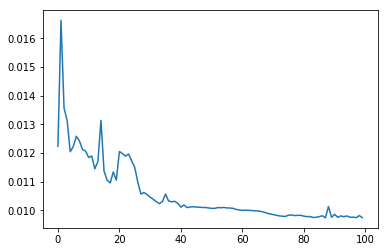

In [26]:
# Plot history loss values during training

loss = [loss_val for i in history for j in i.history.values() for loss_val in j]
pyplot.plot(loss)

In [27]:
# Make a one-step forecast
def forcast_lstm(model, X, batch_size=1):
    X = X.reshape(1, 1, 1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0, 0]

In [28]:
# Forcast the entire training dataset to build up state for forecasting
lstm_model.reset_states()
prediction_train = lstm_model.predict(X, batch_size=1)
prediction_train = Series(prediction_train.squeeze())

In [29]:
# Function that retain the original data format
def reformat(raw_prediction, raw_data, scaler):
    prediction_invert_scale = invert_scale(raw_prediction, scaler)
    #print(prediction_invert_scale)
    pis_invert_diff = list()
    pis_invert_diff.append(raw_data[0])
    #print(pis_invert_diff)
    for i in range(len(prediction_invert_scale)):
        pis_invert_diff.append(invert_difference(raw_data, prediction_invert_scale[i], len(raw_data) - i))
    pis_invert_diff_series = Series(pis_invert_diff)
    return pis_invert_diff_series

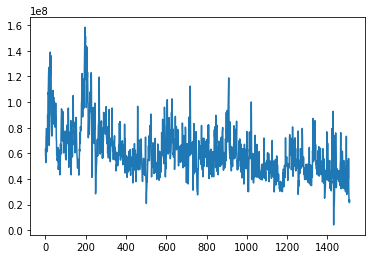

In [30]:
prediction_train_reformat = reformat(prediction_train, raw_data, scaler)
prediction_train_reformat.plot()

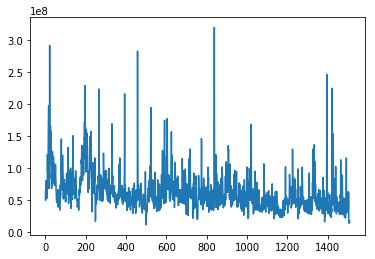

In [31]:
raw_data[:1511].plot()

In [28]:
# Forecast the cross validation dataset
X_cv = cross_val_X_scaled.values.reshape(cross_val_X_scaled.shape[0], 1, 1)
#y = train_y_scaled.values
prediction_cv = lstm_model.predict(X_cv, batch_size=1)
prediction_cv = Series(prediction_cv.squeeze())

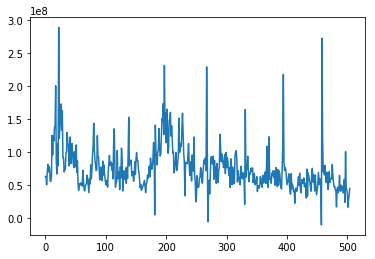

In [29]:
prediction_cv_reformat = reformat(prediction_cv, raw_data, scaler)
prediction_cv_reformat.plot()

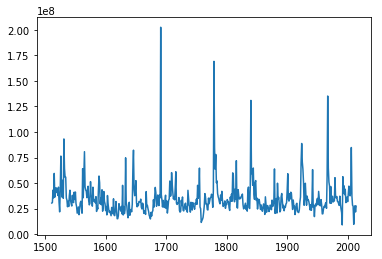

In [30]:
raw_data[1511:2015].plot()